In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import lets_be_rational.LetsBeRational as lbr
from pricing import DiscountingCurve, EquityForwardCurve, Black_closed_form, Black
from montecarlo import Monte_Carlo_Analisys, MC
import time, sys

### Building Model

In [11]:
spot_price = 150
strike = 150
reference = 0
zero_rate = 1/100
volatility = 20/100
maturities = np.arange(1,41)*0.25
kind = -1  #+1 = Call option, -1 put option

In [12]:
discount_curve = DiscountingCurve(reference=reference, zero_rate=zero_rate)
forward = EquityForwardCurve(spot=spot_price, reference=reference, discounting_curve=discount_curve,
                             repo_rates=0, dividend_yelds=0)

B_model = Black(volatility=volatility, forward_curve=forward)

### Simulation

In [13]:
S_t = B_model.simulate(fixings=maturities, Nsim=1e6, seed=10)

In [14]:
price_call = B_model.Vanilla_PayOff(St=S_t, strike = strike, typo = kind)

### Analisys of the convergence of MC results for a fixed strike using data blocking method

In [6]:
x, mean, err = Monte_Carlo_Analisys(price_call,100)

In [7]:
call_black = Black_closed_form(S=spot_price, K=strike, T=maturities, r = zero_rate, q=0, sigma=volatility, typo = kind)

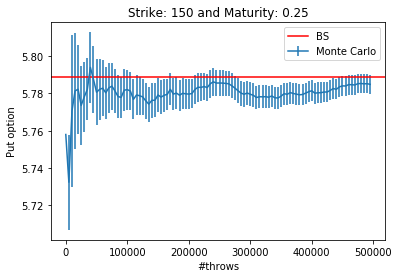

In [8]:
n = 0

mean_price = (mean*discount_curve(maturities)).T[n]
err_price = (err*discount_curve(maturities)).T[n]


plt.errorbar(x,mean_price,yerr=err_price,label = 'Monte Carlo')
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'BS')
plt.xlabel("#throws")
plt.title("Strike: "+str(strike)+" and Maturity: "+str(round(maturities[n],2)))
plt.legend()
if kind==1:
    plt.ylabel('Call option')
    #plt.savefig('Data Blocking_call.pdf')
elif kind==-1:
    plt.ylabel('Put option')
    #plt.savefig('Data Blocking_put.pdf')
plt.show()

C:\Users\Stefano\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


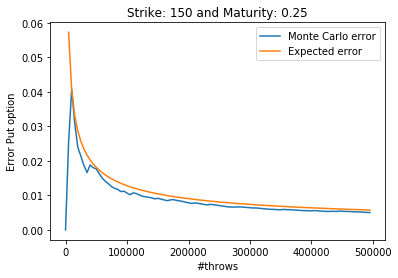

In [9]:
z = np.std(price_call.T[n])
y = np.sqrt(x)
plt.plot(x,err_price, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("Strike: "+str(strike)+" and Maturity: "+str(round(maturities[n],2)))
plt.legend()
if kind==1:
    plt.ylabel('Error Call option')
    #plt.savefig('Error_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error Put option')
    #plt.savefig('Error_put_option.pdf')

plt.show()

### Result for a fixed strike K = 150 in pricing therms

In [10]:
result, result_err = MC(price_call)*discount_curve(maturities)

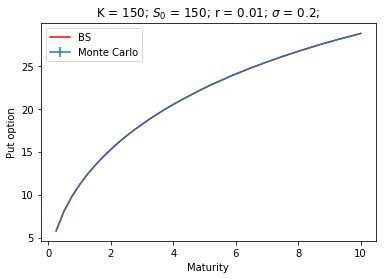

In [11]:
plt.errorbar(maturities,result,yerr=result_err,label = 'Monte Carlo')
plt.plot(maturities,call_black, color = 'red',label = 'BS')
plt.xlabel("Maturity")
plt.title("K = "+str(strike)+"; $S_0$ = "+str(spot_price)+"; r = "+str(zero_rate)+"; $\sigma$ = "+str(volatility)+";")
plt.legend()
if kind==1:
    plt.ylabel('Call option')
    #plt.savefig('Results_Pricing_Calls_strike'+str(strike_price)+'.pdf')
elif kind==-1:
    plt.ylabel('Put option')
    #plt.savefig('Results_Pricing_Put_strike'+str(strike_price)+'.pdf')


#plt.xlim(2.1,2.2)
#plt.ylim(18.6,19)
#plt.savefig('Results/Zoom_2_Pricing_Calls_strike'+str(strike_price)+'.pdf')
plt.show()

### Implied volatility simulation

Prezzo Call, Prezzo Forward, Strike, time to maturity (in year fraction), flag call/put (+1/-1)

In [16]:
K =  np.arange(1,41)*25.#np.array([100.,50,200])#np.linspace(0,5,10)
imp_volatility = np.zeros((len(K),len(maturities)))
imp_volatility_plus = np.zeros((len(K),len(maturities)))
imp_volatility_minus = np.zeros((len(K),len(maturities)))
X_t = S_t/forward(maturities)
E_X = np.mean(X_t,axis=0)
start_time = time.time()
for i in range(len(K)):
    if K[i]/spot_price<=1.:
        kind = -1
    elif K[i]/spot_price>1.:
        kind = 1
    option = B_model.Vanilla_PayOff(St=X_t, strike=(K[i])/forward(maturities),typo=kind)
    result, err_result = MC(option)
    if i%10 == 0:
        print("Running: ",i,"%")
    for j in range(len(maturities)):
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],1.,K[i]/forward(maturities[j]),maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],1.,K[i]/forward(maturities[j]),maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],1.,K[i]/forward(maturities[j]),maturities[j],kind)
        
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
#np.savetxt("Results/norm_implied_volatility_mean.txt",imp_volatility)    #saving results
#np.savetxt("Results/norm_implied_volatility_minus.txt",imp_volatility_minus)    #saving results
#np.savetxt("Results/norm_implied_volatility_plus.txt",imp_volatility_plus)    #saving results
#np.savetxt("Results/norm_strike.txt",K)
#np.savetxt("Results/norm_maturities.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Running:  30 %
Execution time: ---2.123282015323639 min ---
Saving_Files...
COMPLETED


In [5]:
K = np.loadtxt("Results/norm_strike.txt")
maturities = np.loadtxt("Results/norm_maturities.txt")
imp_volatility = np.loadtxt("Results/norm_implied_volatility_mean.txt")
imp_volatility_plus = np.loadtxt("Results/norm_implied_volatility_plus.txt")
imp_volatility_minus = np.loadtxt("Results/norm_implied_volatility_minus.txt")

In [17]:
y_lower = np.zeros((len(K),len(maturities)))
y_upper = np.zeros((len(K),len(maturities)))
for i in range(len(K)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])

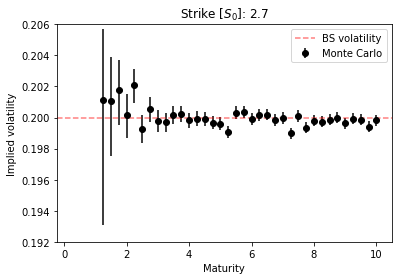

In [48]:
"""Fixed Strike"""  #ATM = 5
num = [15]
c=1
for i in range(len(num)):
    err_lower = y_lower[num[i]]
    err_upper = y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "black",label="Monte Carlo")
   
plt.title("Strike [$S_0$]: "+str(round(K[num[i]]/spot_price,c)))
plt.axhline(y=volatility, color = 'red',alpha = 0.5,linestyle='--',label = 'BS volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
plt.ylim(0.192,0.206)
plt.legend()
plt.savefig("implied_vol_strike"+str(round(K[num[i]]/spot_price,c))+".pdf")

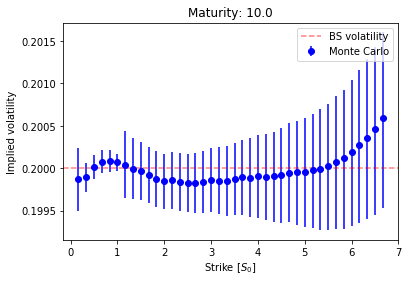

In [63]:
"""Fixed Maturity"""
num = [39]
c=1
for i in range(len(num)):
    err_lower = y_lower.T[num[i]]
    err_upper = y_upper.T[num[i]]
    plt.errorbar(K/spot_price,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="BLUE",label="Monte Carlo")
plt.axhline(y=volatility, color = 'red',alpha = 0.5,linestyle='--',label = 'BS volatility')  
plt.xlabel("Strike [$S_0$]")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
#plt.ylim(0.189,0.214)
plt.legend()
#plt.savefig("implied_vol_maturity"+str(round(maturities[num[i]],c))+".pdf")